In [ ]:
import cv2
import numpy as np
import numpy.linalg as la
import re
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal

In [ ]:
def find_match(des_1,des_2,k):
### Input: 
### des_1: descriptor, a list
### des_2: descriptor, a list
### k: number of best matchings in des_2 compared to des_1
###
### Output:
### a list that has dimension len(dis_1)*k, each entry is a cv2.DMatch() type.

    dist_mat = scipy.spatial.distance.cdist(des_1,des_2,'sqeuclidean') #calculate distance matrix
    matches = []
    for query_ind,query in enumerate(dist_mat):
        train_cand_ind_list = np.argsort(query)[:k] # find k elements with smallest distance
        query_matching = []
        for train_cand_ind in train_cand_ind_list:
            single_match = cv2.DMatch(query_ind,train_cand_ind,0,query[train_cand_ind])
            query_matching.append(single_match)
        matches.append(query_matching)
    return matches

In [2]:
IMG_DIR = 'image_0/'
IMG_NAME_1 = '000000.png'
IMG_NAME_2 = '000001.png'

In [3]:
img_1 = cv2.imread(IMG_DIR + IMG_NAME_1)
img_2 = cv2.imread(IMG_DIR + IMG_NAME_2)

sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img_1,None)
kp2, des2 = sift.detectAndCompute(img_2,None)
SIFT_1 = cv2.drawKeypoints(img_1, kp1, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
SIFT_2 = cv2.drawKeypoints(img_2, kp2, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

In [4]:
# FLANN_INDEX_KDTREE = 0
# index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
# search_params = dict(checks=50)
# flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = find_match(des1,des2,k=2)
good = []
pts1 = []
pts2 = []
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)
        
pts1_E = np.asarray(pts1)
pts2_E = np.asarray(pts2)

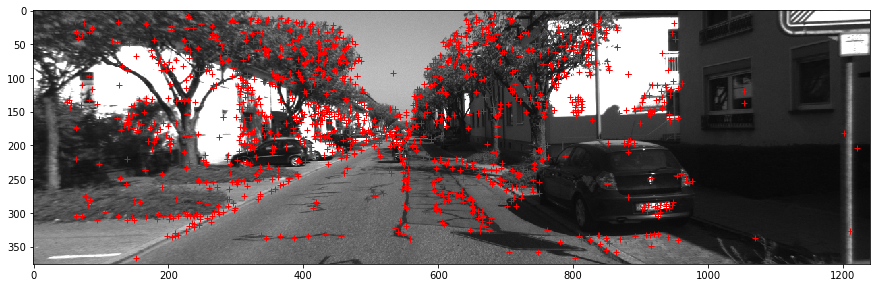

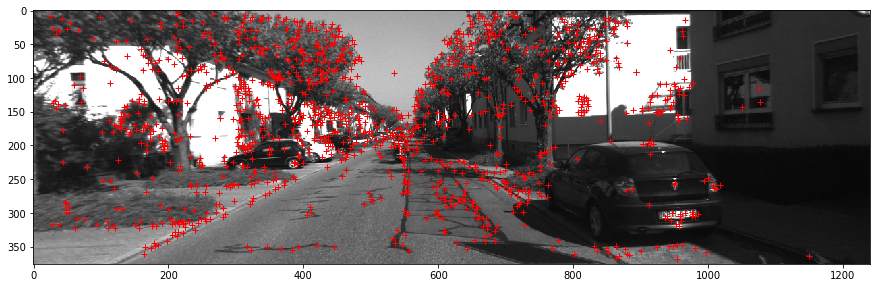

In [5]:
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(np.array(img_1).astype(int))
pt1 = np.array(pts1)
ax.plot(pt1[:,0],pt1[:,1],  '+r')
plt.show()

fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(np.array(img_2).astype(int))
pt2 = np.array(pts2)
ax.plot(pt2[:,0],pt2[:,1],  '+r')
plt.show()

# findEssentialMat & recoverPose

In [6]:
# Find Intrinsic Parameters
with open('KITTI  sample dataset/dataset/sequences/00/calib.txt', 'r') as f:
    P = re.split('\n| ', f.read())
P0 = np.array([float(x) for x in P[1:13]]).reshape((3,4))
fl = P0[0, 0]
pp = (P0[0, 2], P0[1, 2])

In [7]:
def compute_residual(matches, F):
    N = len(matches)
    residual = 0
    M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
    L1 = np.matmul(F, M).transpose()
    l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
    L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())
    pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
    residual += pt_line_dist**2
    M = np.c_[matches[:,2:4], np.ones((N,1))].transpose()
    L1 = np.matmul(F.T, M).transpose()
    l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
    L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())
    pt_line_dist = np.multiply(L, np.c_[matches[:,0:2], np.ones((N,1))]).sum(axis = 1)
    residual += pt_line_dist**2
    return residual

def fit_fundamental(matches, num_iterations, inlier_threshold):
    inlier_max = [-1, -1]
    F_max = None
    mask_max = None
    for i in range(num_iterations):
        index = np.random.choice(len(matches), 8, replace=False)
        new_matches = matches[index]
        T = []
        for j in range(2):
            center = np.mean(new_matches[:,j*2:j*2+2], axis=0)
            new_matches[:,j*2:j*2+2] -= center
            scale = np.mean(np.linalg.norm(new_matches[:,j*2:j*2+2], axis=1)**2/2)**0.5
            new_matches[:,j*2:j*2+2] /= scale
            T.append(np.array([[1/scale,0,-center[0]/scale], [0,1/scale,-center[1]/scale], [0,0,1]]))
        N = len(new_matches)
        u1 = new_matches[:,0]
        v1 = new_matches[:,1]
        u2 = new_matches[:,2]
        v2 = new_matches[:,3]

        A = np.c_[u1*u2,u2*v1,u2,v2*u1,v2*v1,v2,u1,v1,np.ones(N)]
        U, s, V = np.linalg.svd(A)
        F = V[len(V)-1].reshape((3,3))

        U, s, V = np.linalg.svd(F)
        s[-1] = 0
        F = U @ np.diag(s) @ V
        F = T[1].T @ F @ T[0]
        residual = compute_residual(matches, F)
        mask = np.ma.masked_less(residual, inlier_threshold)
        inlier = mask.mask.sum()
        if inlier > inlier_max[1]:
            inlier_max = [i, inlier]
            F_max = F
            mask_max = mask.mask
    mask_max = (mask_max.reshape((1, len(mask_max))).T*1).astype('uint8')
    return F_max, mask_max

def findEssentialMat(pts1_E, pts2_E, focal=1.0, pp=(0, 0), num_iterations=100, inlier_threshold=0.5):
    matches = np.hstack([pts1_E, pts2_E])
    F, mask = fit_fundamental(matches, num_iterations, inlier_threshold)
    K = np.array([[focal,0,pp[0]],[0,focal,pp[1]],[0,0,1]])
    E = K.T @ F @ K
    return E, mask

In [13]:
def decomposeEssentialMat(E):
    u, s, vh = np.linalg.svd(E)
    if la.det(u) < 0:
        u *= -1
    if la.det(vh) < 0:
        vh *= -1
    w = np.array([[0,1,0], [-1,0,0], [0,0,1]])
    R1 = u @ w @ vh
    R2 = u @ w.T @ vh
    t = u[:,2]
    return R1, R2, t

def recoverPose(E_own, pts1_E, pts2_E, mask=[]):
    R1, R2, t = decomposeEssentialMat(E)
    P0 = np.eye(3, 4)
    P = np.zeros((4, 3, 4))
    P[0] = np.c_[R1, t]
    P[1] = np.c_[R2, t]
    P[2] = np.c_[R1, -t]
    P[3] = np.c_[R2, -t]
    
    N = len(pts1_E)
    mask_4 = np.zeros((4, N))
    for i in range(4):
        X_N = np.zeros((4, N))
        for j in range(N):
            A = np.zeros((4, 4))
            A[0] = pts1_E[j,0] * P0[2] - P0[0]
            A[1] = pts1_E[j,1] * P0[2] - P0[1]
            A[2] = pts2_E[j,0] * P[i,2] - P[i,0]
            A[3] = pts2_E[j,1] * P[i,2] - P[i,1]
            U, s, V = np.linalg.svd(A)
            X = V[len(V)-1]
            X_N[:,i] = X
        mask_4[i] = (X_N[2] * X_N[3]) > 0
        X_N = P[i] @ X_N
        mask_4[i] = np.logical_and(X_N[2]>0, mask_4[i])
    if len(mask):
        for i in range(4):
            mask_4[i] = np.logical_and(mask.T, mask_4[i])

    good = mask_4.sum(axis=1)
    _R = None
    _t = None
    if good[0]>=good[1] and good[0]>=good[2] and good[0]>=good[3]:
        _R = R1
        _t = t
    elif good[1]>=good[0] and good[1]>=good[2] and good[1]>=good[3]:
        _R = R2
        _t = t
    elif good[2]>=good[0] and good[2]>=good[1] and good[2]>=good[3]:
        _R = R1
        _t = -t
    else:
        _R = R2
        _t = -t
    _t = _t.reshape((1, len(_t))).T
    return _R, _t

In [14]:
# EssentialMatrix cv2
E, mask = cv2.findEssentialMat(pts1_E, pts2_E, focal=fl, pp=pp)
_, R, t, _ = cv2.recoverPose(E, pts1_E, pts2_E, focal=fl, pp=pp, mask=mask)

# EssentialMatrix own version
E_own, mask_own = findEssentialMat(pts1_E, pts2_E, focal=fl, pp=pp)
R_own, t_own = recoverPose(E_own, pts1_E, pts2_E, mask=mask_own)

In [15]:
print('Essential:\n', E)
print('Essential_own:\n', E_own)
print('-'*100)
print('Total_points:', len(mask))
print('Inlier_points:', mask.sum())
print('Inlier_points_own:', mask_own.sum())
print('-'*100)
print('Rotation:\n', R)
print('Rotation_own:\n', R_own)
print('-'*100)
print('Translation:\n', t)
print('Translation_own:\n', t_own)

Essential:
 [[ 1.43674085e-03 -7.07104644e-01  8.04792139e-04]
 [ 7.07097737e-01  1.43748992e-03  2.29092037e-03]
 [-2.33894484e-03 -5.62052284e-04 -6.94731151e-06]]
Essential_own:
 [[-4.27042459e-02  1.53929587e+01 -9.40548117e-02]
 [-1.53747401e+01 -9.11844314e-02  3.52990495e-01]
 [ 1.35824728e-01 -4.17259619e-01 -5.37347722e-04]]
----------------------------------------------------------------------------------------------------
Total_points: 1427
Inlier_points: 989
Inlier_points_own: 1091
----------------------------------------------------------------------------------------------------
Rotation:
 [[ 0.99999492  0.00203464  0.00245174]
 [-0.00203997  0.99999556  0.00217124]
 [-0.00244731 -0.00217623  0.99999464]]
Rotation_own:
 [[ 0.99999492  0.00203464  0.00245174]
 [-0.00203997  0.99999556  0.00217124]
 [-0.00244731 -0.00217623  0.99999464]]
----------------------------------------------------------------------------------------------------
Translation:
 [[ 7.88132023e-04]
 [-3